### Laboration deep learning AI21
---
Syftet med den här labben är att använda deep learning för computer vision för att lära sig att klassificera
olika objekt.
I den här labben kommer du få jobba med bildbehandling, filhantering, bygga upp egna tränings, validerings
och testdataset från en mängd av bilder. Vidare får du jobba med begränsade datamängder för att efterlikna
verkligheten när dataanskaffning är en oerhört dyr process. Efter databehandlingen och databearbetningen
kommer du få pröva olika slags convolutional neural networks tränade från scratch och slutligen använda
dig av transfer learning för att återanvända nätverk skapade av toppforskare inom computer vision.

---
0. EDA och filhantering (*)

a) Börja med att ladda ned datasetet Dogs vs Cats från Kaggle. Extrahera den och lägg den i din labfolder,
glöm inte att lägga till den till .gitignore.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import random
import os
import shutil


plt.style.use("seaborn-white")

In [2]:
train_dir = os.path.abspath("original_data/train/train/")
test_dir = os.path.abspath("original_data/test/test/")


files_train_dir = os.listdir(train_dir)
files_test_dir = os.listdir(test_dir)

images_names = pd.DataFrame({"file_name" : files_train_dir})
print(f"total number of images: {len(images_names)}")
images_names.head(10)

df_cat = images_names[images_names["file_name"].str.contains("cat")==True]
df_dog = images_names[images_names["file_name"].str.contains("dog")==True]

print(f"number of cats: {len(df_cat)}, number of dogs: {len(df_dog)}")

total number of images: 25000
number of cats: 12500, number of dogs: 12500


In [3]:
df_cat

,file_name
0,cat.0.jpg
1,cat.1.jpg
2,cat.10.jpg
3,cat.100.jpg
4,cat.1000.jpg
...,...
12495,cat.9995.jpg
12496,cat.9996.jpg
12497,cat.9997.jpg
12498,cat.9998.jpg


In [4]:
df_dog

,file_name
12500,dog.0.jpg
12501,dog.1.jpg
12502,dog.10.jpg
12503,dog.100.jpg
12504,dog.1000.jpg
...,...
24995,dog.9995.jpg
24996,dog.9996.jpg
24997,dog.9997.jpg
24998,dog.9998.jpg


b) Läs in 10 bilder slumpmässigt, plotta dem och extrahera deras labels och skriv ut i titeln.

In [5]:
# plot dog photos from the dogs vs cats dataset
import matplotlib.pyplot as plt
import random
from matplotlib.image import imread

def pick_images(n_of_images=10, folder = train_dir):
    images = []
	# generate a list of ten random labels among 'cat', and 'dog'
	# generate a list of ten random numbers
	# these ten labels+numbers pick ten random images saved in images list
    labels = [random.choice(["cat", "dog"]) for i in range(n_of_images)]
    numbers = random.sample(range(len(df_cat)), n_of_images)


	# randomly pick ten images according to randomly picked labels and numbers
    for label, number in zip(labels, numbers):
        image = plt.imread(f"{folder}/{label}.{number}.jpg")
		# save the image to images list
        images.append(image)
    return images, labels


def display_images(images, labels, n_of_images=10, nrows = 2, ncols = 5, figsize = (20,20)):

    fig, axes = plt.subplots(nrows, ncols, figsize = figsize)
	
    for i, ax, label in zip(range(n_of_images), axes.flatten(), labels):
        ax.imshow(images[i])
        ax.axis("off")
        ax.set(title=label)

    fig.subplots_adjust(wspace=0.1, hspace=0.1, bottom=0.01, top=0.4)


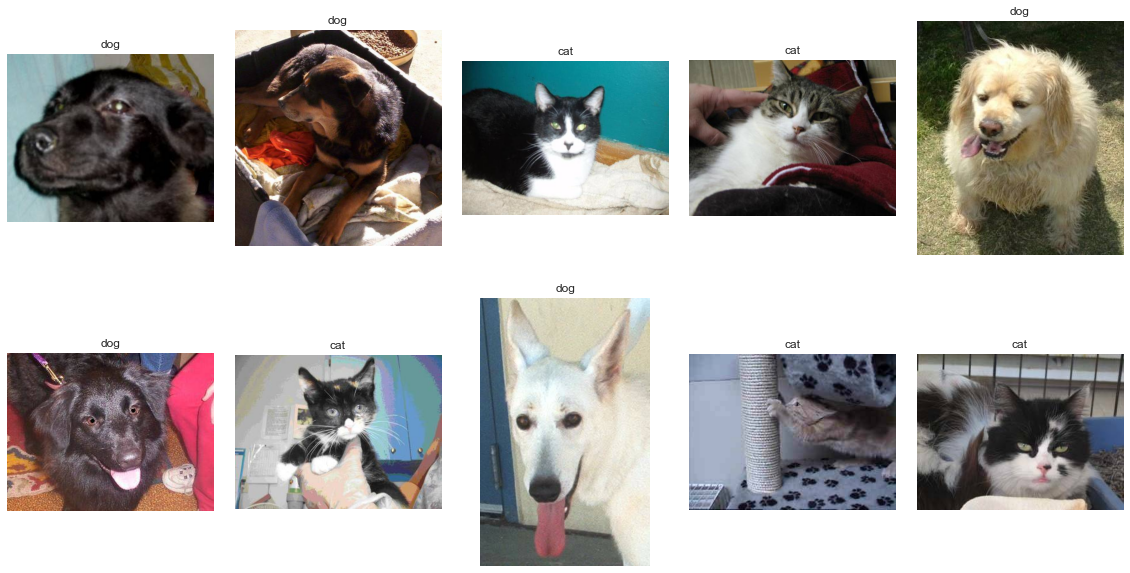

In [6]:
images, labels = pick_images()
display_images(images, labels)

train_dir="/kaggle/input/dogs-vs-cats/train/train"
len(os.listdir(train_dir))
test_dir="/kaggle/input/dogs-vs-cats/test/test"
len(os.listdir(train_dir))

c) Skapa folderstrukturen nedan med Python, Notera att det är okej att ha fler pythonskript, notebooks, fler experiment, eller annat relevant i labbfoldern. Glöm inte att ha gitignore på datafilerna.

d) Nu ska du göra train|val|test split med följande splits:

experiment_small
- train - 1600 (800 dogs, 800 cats)
- val - 400 (200 dogs, 200 cats)
- test - 500 (250 dogs, 250 cats)

experiment_tiny (BONUS)
- train - 160 (80 dogs, 80 cats)
- val - 40 (20 dogs, 20 cats)
- test - 50 (25 dogs, 25 cats)

In [7]:
def train_val_test(data, n_train_each_label=800, n_val_each_label=200, n_test_each_label=250):
    n_of_images = n_train_each_label + n_val_each_label + n_test_each_label
    data_full = random.sample(list(data), n_of_images)

    train_data = random.sample(data_full, n_train_each_label)
    val_data = random.sample(data_full, n_val_each_label)
    test_data = random.sample(data_full, n_test_each_label)

    return train_data, val_data, test_data


In [8]:
def combine_data(train_cat, val_cat, test_cat, train_dog, val_dog, test_dog ):
    train_data = train_cat + train_dog
    val_data = val_cat + val_dog
    test_data = test_cat + test_dog
    return train_data, val_data, test_data

In [9]:
def save_images(processed_images_path, data):
    # create the folder processed_images
    try: 
        os.mkdir(processed_images_path)
    except FileExistsError as err:
        shutil.rmtree(processed_images_path)
        # remove the folder if it exists
        os.mkdir(processed_images_path)
        # create the folder
    for img_name in data:
        source_path = f"{train_dir}/{img_name}"
        target_path = f"{processed_images_path}/{img_name}"
        shutil.copyfile(source_path, target_path)

In [10]:
train_cat, val_cat, test_cat = train_val_test(list(df_cat['file_name']))
train_dog, val_dog, test_dog = train_val_test(list(df_dog['file_name']))

In [11]:
train_data, val_data, test_data = combine_data(train_cat, val_cat, test_cat, train_dog, val_dog, test_dog)
len(train_data), len(val_data), len(test_data)

(1600, 400, 500)

In [12]:
processed_images_path ='experiment_small_data/train/'
save_images(processed_images_path, train_data)

In [13]:
processed_images_path ='experiment_small_data/val/'
save_images(processed_images_path, val_data)

In [14]:
processed_images_path ='experiment_small_data/test/'
save_images(processed_images_path, test_data)

In [15]:
train_cat, val_cat, test_cat = train_val_test(list(df_cat['file_name']),n_train_each_label=80, n_val_each_label=20, n_test_each_label=25)
train_dog, val_dog, test_dog = train_val_test(list(df_dog['file_name']), n_train_each_label=80, n_val_each_label=20, n_test_each_label=25)
train_data, val_data, test_data = combine_data(train_cat, val_cat, test_cat, train_dog, val_dog, test_dog)
len(train_data), len(val_data), len(test_data)

(160, 40, 50)

In [16]:
processed_images_path ='experiment_tiny_data/train/'
save_images(processed_images_path, train_data)

In [17]:
processed_images_path ='experiment_tiny_data/val/'
save_images(processed_images_path, val_data)

In [18]:
processed_images_path ='experiment_tiny_data/test/'
save_images(processed_images_path, test_data)

for img_name in train_data:
    source_path = f"{train_dir}/{img_name}"
    target_path = f"{processed_images_path}/{img_name}"
    shutil.copyfile(source_path, target_path)


e) Läs in dataseten från experiment_small, experiment_tiny och plocka ut labelsvektorer, som ska vara
one-hot encoded med 0 och 1.
- plotta några bilder med deras respektive labels och kontrollera att det är korrekt.


In [19]:
def get_label(datadir):
    data=[]
    labels=[]
    images=[]
    CATEGORIES = ["cat", "dog"]

    imagefiles=[os.path.join(datadir,f) for f in os.listdir(datadir)]
    for image in imagefiles:
        category = image.split('/')[-1].split('.')[0]
        img = cv2.imread(image)
        data.append([img, CATEGORIES.index(category)])
        np.random.seed(42)
        np.random.shuffle(data)
    for features,label in data:
        images.append(features)
        labels.append(label)
    
    return images, labels

In [20]:
X_train_small, y_train_small = get_label("experiment_small_data/train/")
X_val_small, y_val_small  = get_label("experiment_small_data/val/")
X_test_small, y_test_small = get_label("experiment_small_data/test/")

X_train_tiny, y_train_tiny = get_label("experiment_tiny_data/train/")
X_val_tiny, y_val_tiny = get_label("experiment_tiny_data/val/")
X_test_tiny, y_test_tiny = get_label("experiment_tiny_data/test/")

In [21]:
X_train_tiny

[array([[[ 42,  98,  63],
         [ 37,  93,  58],
         [ 40,  96,  61],
         ...,
         [123, 199, 151],
         [114, 193, 142],
         [109, 188, 137]],
 
        [[ 31,  87,  52],
         [ 29,  85,  50],
         [ 34,  90,  55],
         ...,
         [122, 198, 150],
         [115, 194, 143],
         [113, 192, 141]],
 
        [[ 29,  86,  48],
         [ 30,  87,  49],
         [ 38,  95,  57],
         ...,
         [124, 197, 151],
         [117, 193, 145],
         [116, 192, 144]],
 
        ...,
 
        [[138, 214, 172],
         [112, 191, 148],
         [107, 186, 143],
         ...,
         [133, 212, 163],
         [126, 205, 154],
         [125, 201, 153]],
 
        [[117, 201, 153],
         [ 99, 183, 135],
         [104, 187, 142],
         ...,
         [120, 201, 152],
         [120, 201, 152],
         [122, 200, 153]],
 
        [[112, 199, 149],
         [ 94, 181, 131],
         [100, 185, 140],
         ...,
         [111, 191, 144],
  

In [22]:
y_train_tiny

[1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0]

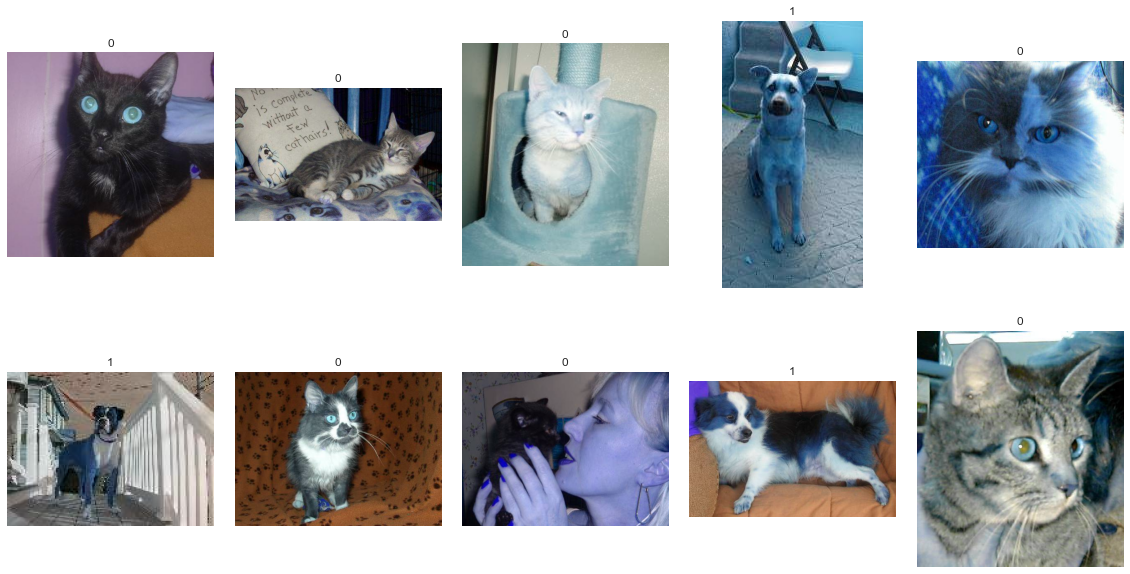

In [23]:
display_images(X_train_small, y_train_small)

- skapa lämplig plot för att kontrollera att dataseten är balanserade


In [24]:
data = [y_train_small, y_val_small, y_test_small, y_train_tiny, y_val_tiny, y_test_tiny]
dataset_name = ["Small Dataset train", "Small Dataset val", "Small Dataset test", "Tiny Dataset train", "Tiny Dataset val", "Tiny Dataset test"]

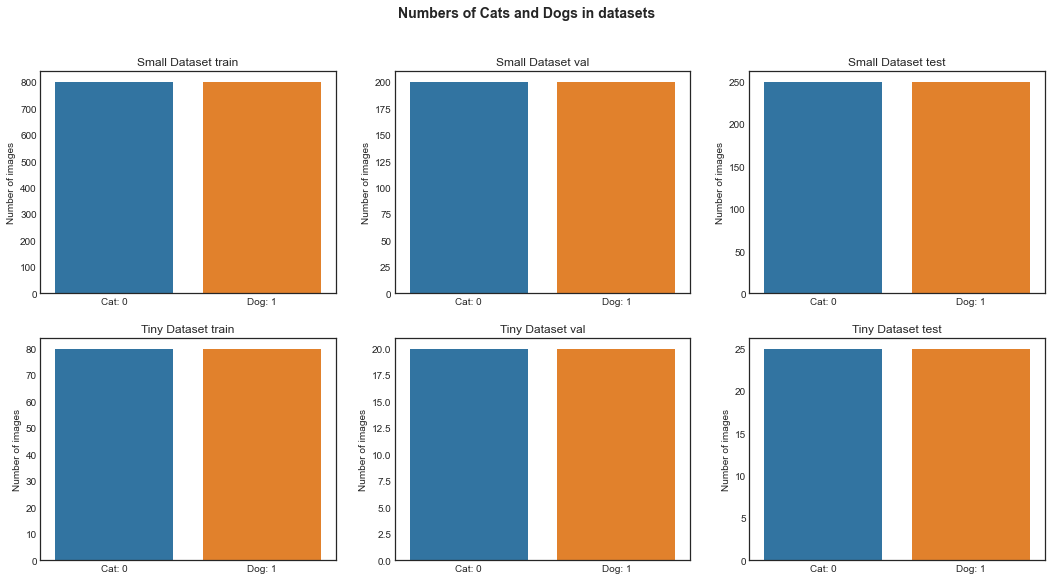

In [25]:
fig, axes = plt.subplots(2, 3, figsize=(18, 9))

for ax, dataset, name in zip(axes.flatten(), data, dataset_name):
    sns.countplot(x=dataset, ax=ax)
    ax.set(title=name, ylabel="Number of images")
    ax.set_xticklabels(["Cat: 0", "Dog: 1"], size=10)

fig.suptitle("Numbers of Cats and Dogs in datasets", size=14, fontweight="bold");

- skapa lämplig plot för att kontrollera att dataseten är slumpade (dvs inte ex [0, 0, ... 0, 1, 1, ..., 1]).

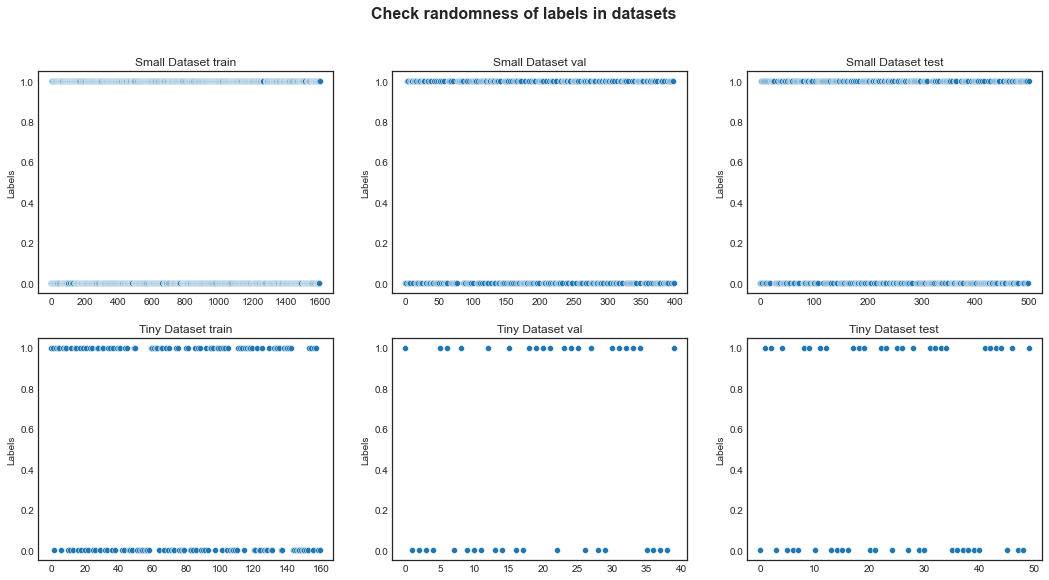

In [26]:
fig, axes = plt.subplots(2, 3, figsize=(18, 9))

for ax, dataset, name in zip(axes.flatten(), data, dataset_name):
    sns.scatterplot(data=dataset, ax=ax)
    ax.set(title=name, ylabel="Labels")
    ax.yticklabels=[0,1]

fig.suptitle("Check randomness of labels in datasets", size=16, fontweight="bold");